# PSOVA1
- Inertia Weight (w): It is a fixed parameter in your code but could be adjusted in PSOVA1 for dynamic control of exploration vs. exploitation.
- Cognitive and Social Constants (c1, c2): Similarly, in PSOVA1, these constants could be varied based on performance, adapting the search to focus on exploration or exploitation at different stages.
- Hybrid Dispatching and Leader Enhancement: These techniques are used to improve search diversity and adjust the global leader dynamically to enhance convergence to a better solution.
- Nonlinear Velocity Coefficients: The random generation of velocity coefficients allows the algorithm to adjust its search behavior based on the particle's individual performance.

# Problem:
1. Premature Convergence: The algorithm is likely converging too early to a suboptimal solution, meaning that particles are not exploring new areas of the solution space.

2. Inadequate Exploration: While the inertia weight and Gaussian noise have been adjusted to encourage exploration, if the velocity or position update steps aren't large enough (or there is too much penalty for feature selection), the algorithm may fail to explore the space effectively.

3. Penalties and Objective Function: If the penalty term for feature selection is too large or if the objective function itself is too restrictive, the algorithm might not allow particles to search beyond the penalty and stay stuck in a suboptimal solution.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../..')))

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "../.."))
LOGS_DIR = os.path.join(ROOT_DIR, 'logs')

In [3]:
file_path = ROOT_DIR+'\\data\\processed\\WSN-DS_balance.csv'
df = pd.read_csv(file_path)
df.head()

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Attack type
0,606079,3053,1,606100,0.00000,1,27,0,0,0,0,0,0,0,0,0.00000,0,0.04985,Grayhole
1,406039,1953,1,406100,0.00000,1,22,0,0,0,0,0,0,0,0,0.00000,0,0.39332,Blackhole
2,303085,1653,0,303006,2.96837,0,13,1,0,0,1,3,0,0,0,0.00000,8,0.00594,Normal
3,402086,2003,1,402100,0.00000,1,25,0,0,0,0,0,0,0,0,0.00000,0,0.05020,Grayhole
4,603098,2753,1,603100,0.00000,1,10,0,1,1,0,0,0,234,234,126.74493,0,2.48271,TDMA


Iteration 1: Best score = 131190.0
Iteration 2: Best score = 131190.0
Iteration 3: Best score = 131190.0
Iteration 4: Best score = 131190.0
Iteration 5: Best score = 131190.0
Iteration 6: Best score = 131190.0
Iteration 7: Best score = 131190.0
Iteration 8: Best score = 131190.0
Iteration 9: Best score = 131190.0
Iteration 10: Best score = 131190.0
Iteration 11: Best score = 131190.0
Iteration 12: Best score = 131190.0
Iteration 13: Best score = 131190.0
Iteration 14: Best score = 131190.0
Iteration 15: Best score = 131190.0
Iteration 16: Best score = 131190.0
Iteration 17: Best score = 131190.0
Iteration 18: Best score = 131190.0
Iteration 19: Best score = 131190.0
Iteration 20: Best score = 131190.0
Iteration 21: Best score = 131190.0
Iteration 22: Best score = 131190.0
Iteration 23: Best score = 131190.0
Iteration 24: Best score = 131190.0
Iteration 25: Best score = 131190.0
Iteration 26: Best score = 131190.0
Iteration 27: Best score = 131190.0
Iteration 28: Best score = 131190.0
I

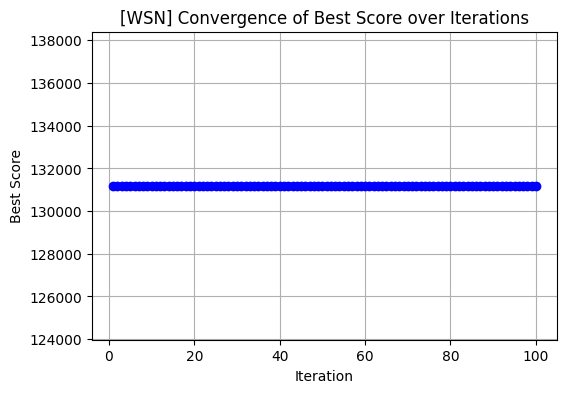

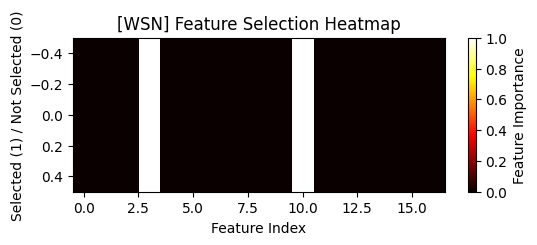



Mean Best Score: 131190.0
Standard Deviation of Best Score: 0.0
Mean Classification Accuracy: 0.6306834894341667
Standard Deviation of Classification Accuracy: 0.003987210741676507



In [22]:
random_state = 1922
np.random.seed(random_state)

# Load Parkinson's dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    features = data.iloc[:, 1:-1].copy()  # Explicitly create a copy of the DataFrame
    labels = data.iloc[:, -1].values
    encoder = LabelEncoder()

    # Now using .loc to ensure modification is done safely
    for col in features.columns:
        if features[col].dtype == 'object':
            features.loc[:, col] = encoder.fit_transform(features[col])

    features = features.values
    return features, labels

features, labels = load_data(file_path)

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# PSOVA1 Parameters
W = 0.7
c1 = 1.2  # Cognitive constant
c2 = 1.8  # Social constant
max_iter = 100
swarm_size = 30
pswitch = 0.5

# Objective Function for PSOVA1
def objective_function(x, features, iteration = 0):
    selected_features = features[:, x.astype(bool)]
    score = np.sum(np.square(selected_features)) if selected_features.size > 0 else 0
    penalty = (1000 * np.sum(x)) / (1 + iteration)  # [⚡Improvement] Reducing penalty over iterations
    return score + penalty

# Particle initialization
def initialize_particles(dim, swarm_size):
    positions = (np.random.rand(swarm_size, dim) < 0.5).astype(int)
    velocities = np.random.uniform(-1, 1, (swarm_size, dim))
    return positions, velocities

# Equation 1: Velocity update with dynamic inertia weight for exploration
'''
[1.1] Rectified (non-negative) personal best influence
[1.2] Rectified (non-negative) global best influence
The velocity update here uses the best positions, both personal best (pbest) and global best (gbest),
and adjusts them dynamically during the optimization process.
This rectifies the influence of global and personal best signals.
'''
def update_velocity(velocity, position, pbest, gbest, iteration, max_iter, c1, c2):
    # Increase inertia weight for exploration
    w = W - (3 * iteration / max_iter)  # [⚡Improvement] Gradually reduce inertia weight to balance exploration and exploitation
    r1, r2 = np.random.rand(*position.shape[1:]), np.random.rand(*position.shape[1:])
    inertia = w * velocity
    cognitive = c1 * r1 * np.maximum(pbest - position, 0)       # [1.1]
    social = c2 * r2 * np.maximum(gbest - position, 0)          # [1.2]
    gaussian_noise = np.random.normal(1, 5, position.shape)   # [⚡Improvement] Larger Gaussian noise for exploration
    return inertia + cognitive + social + gaussian_noise

# Equation 2: Position update
def update_position(position, velocity):
    new_position = position + np.round(velocity).astype(int)
    return (new_position > 0).astype(int)

# Equation 3: Gaussian Leader Enhancement
'''
[2] Gaussian distribution based swarm leader enhancement
The global best (leader) is enhanced using Gaussian distribution to fine-tune the search.
This approach helps in exploring the search space and potentially avoiding local optima.
'''
def gaussian_leader_enhancement(gbest, upper_bound, lower_bound):
    alpha = 0.1
    gaussian_noise = np.random.normal(1, 5)  # [⚡Improvement] Gaussian noise to introduce perturbation
    return gbest + alpha * gaussian_noise * (upper_bound - lower_bound)

# Equation 4: Mirroring-based Mutation
'''
[4] Mirroring-based mutation operation
Mirroring-based Mutation is a type of mutation operation often used in optimization algorithms 
to improve the diversity of solutions and escape local optima.
'''
def mirroring_mutation(gbest):
    mutation_probability = 0.1
    new_solution = np.where(np.random.rand(gbest.shape[0]) < mutation_probability, ~gbest.astype(bool), gbest)
    return new_solution.astype(int)

# Equations 5-6: Differential Evolution-based Mutation
'''
[4] Differential Evolution mutation for worst solution improvement
Differential Evolution (DE) mutation and mirroring strategies are used to improve the worst solutions.
This helps diversify the swarm and avoid stagnation at local optima.
'''
def de_mutation(pbest1, pbest2, pbest3):
    F = np.random.rand()
    donor = pbest1 ^ (pbest2 ^ pbest3)
    return donor

# Equation 7: Annealing Schedule for Acceptance
def annealing_acceptance(delta_f, temperature):
    value = -delta_f / temperature
    value = np.clip(value, -709, 709)
    return np.exp(value) > np.random.rand()

# Equation 11: Spiral-based Local Exploitation
'''
[5] Spiral search based local exploitation
A spiral pattern search mechanism for local exploitation (fine-tuning the solutions) is employed here.
It involves adjusting particle positions according to a spiral function for better convergence.
'''
def spiral_search(gbest, particle_position):
    l = np.random.uniform(-1, 1)
    D = np.abs(gbest - particle_position)
    return D * np.exp(l) * np.cos(2 * np.pi * l) + gbest

# Main PSOVA1 algorithm
def PSOVA1(features, labels, c1, c2, max_iter=100, swarm_size=30):
    dim = features.shape[1]
    positions, velocities = initialize_particles(dim, swarm_size)
    pbest_positions = np.copy(positions)
    pbest_scores = np.array([objective_function(p, features) for p in pbest_positions])
    gbest_position = pbest_positions[np.argmin(pbest_scores)]
    gbest_score = np.min(pbest_scores)

    best_scores_over_time = []
    temperature = 1.0

    for iteration in range(max_iter):
        for i in range(swarm_size):
            if pbest_scores[i] < gbest_score:
                gbest_position = pbest_positions[i]
                gbest_score = pbest_scores[i]

        for i in range(swarm_size):
            velocities[i] = update_velocity(velocities[i], positions[i], pbest_positions[i], gbest_position, i, max_iter, c1, c2)
            positions[i] = update_position(positions[i], velocities[i])

            fitness = objective_function(positions[i], features, i)
            if fitness < pbest_scores[i]:
                pbest_positions[i] = positions[i]
                pbest_scores[i] = fitness
            if fitness < gbest_score:
                gbest_position = positions[i]
                gbest_score = fitness

        best_scores_over_time.append(gbest_score)
        print(f"Iteration {iteration + 1}: Best score = {gbest_score}")
        temperature *= 0.9

    return gbest_position, gbest_score, best_scores_over_time

# Classification accuracy calculation
def calculate_accuracy(features, labels, best_position, num_trials=10):
    accuracies = []
    selected_features = features[:, best_position.astype(bool)]

    for _ in range(num_trials):
        X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.2, random_state=None)
        classifier = LogisticRegression(max_iter=500)
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Run PSOVA1 on Parkinson's dataset and capture best score over time
best_position, best_score, best_scores_over_time = PSOVA1(features, labels, c1, c2, 100, 30)
mean_accuracy, std_accuracy = calculate_accuracy(features, labels, best_position)

# Calculate mean and standard deviation of best scores
mean_score = np.mean(best_scores_over_time)
std_score = np.std(best_scores_over_time)

# Visualization of best score over iterations
print("")
print("="*110)
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_iter + 1), best_scores_over_time, marker='o', color='b')
plt.xlabel('Iteration')
plt.ylabel('Best Score')
plt.title('[WSN] Convergence of Best Score over Iterations')
plt.grid()
plt.show()

# Visualize best position in a feature heatmap
plt.figure(figsize=(6, 2))
plt.imshow(best_position.reshape(1, -1), cmap='hot', aspect='auto')
plt.colorbar(label='Feature Importance')
plt.title('[WSN] Feature Selection Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.show()

# Print results
print("")
print("="*110)
print("")
print("Mean Best Score:", mean_score)
print("Standard Deviation of Best Score:", std_score)
print("Mean Classification Accuracy:", mean_accuracy)
print("Standard Deviation of Classification Accuracy:", std_accuracy)
print("")
print("="*110)

In [10]:
import optuna

c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import optuna

def objective(trial):
    c1 = trial.suggest_float("c1", 0.5, 2.0)
    c2 = trial.suggest_float("c2", 0.5, 2.0)
    swarm_size = trial.suggest_int("swarm_size", 10, 50)
    
    # Run PSOVA1
    best_position, best_score, best_scores_over_time = PSOVA1(features, labels, c1, c2, 100, swarm_size)
    mean_accuracy, std_accuracy = calculate_accuracy(features, labels, best_position)

    # Calculate mean and standard deviation of best scores
    # mean_score = np.mean(best_scores_over_time)
    # std_score = np.std(best_scores_over_time)
    
    # Define objective value (smaller is better)
    return best_score - mean_accuracy  # Adjust weights if necessary

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-11-26 19:56:07,091] A new study created in memory with name: no-name-8ed92006-f1e9-44ba-87d1-3f69a8733690


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 323429.5454545454
Iteration 3: Best score = 323429.5454545454
Iteration 4: Best score = 323091.27906976745
Iteration 5: Best score = 323091.27906976745
Iteration 6: Best score = 323091.27906976745
Iteration 7: Best score = 323091.27906976745
Iteration 8: Best score = 323091.27906976745
Iteration 9: Best score = 323091.27906976745
Iteration 10: Best score = 323091.27906976745
Iteration 11: Best score = 258485.26315789475
Iteration 12: Best score = 258485.26315789475
Iteration 13: Best score = 258485.26315789475
Iteration 14: Best score = 258482.56410256407
Iteration 15: Best score = 258482.56410256407
Iteration 16: Best score = 258482.56410256407
Iteration 17: Best score = 258482.56410256407
Iteration 18: Best score = 258482.56410256407
Iteration 19: Best score = 258482.56410256407
Iteration 20: Best score = 258482.56410256407
Iteration 21: Best score = 258482.56410256407
Iteration 22: Best score = 193848.829787234
Iteration 2

[I 2024-11-26 19:56:50,305] Trial 0 finished with value: 129284.34757739615 and parameters: {'c1': 1.4678669723394577, 'c2': 1.9415238916880329, 'swarm_size': 50}. Best is trial 0 with value: 129284.34757739615.


Iteration 1: Best score = 196784.99999999997
Iteration 2: Best score = 196784.99999999997
Iteration 3: Best score = 196784.99999999997
Iteration 4: Best score = 196784.99999999997
Iteration 5: Best score = 196784.99999999997
Iteration 6: Best score = 196784.99999999997
Iteration 7: Best score = 196784.99999999997
Iteration 8: Best score = 196784.99999999997
Iteration 9: Best score = 196784.99999999997
Iteration 10: Best score = 196784.99999999997
Iteration 11: Best score = 196784.99999999997
Iteration 12: Best score = 196784.99999999997
Iteration 13: Best score = 196784.99999999997
Iteration 14: Best score = 196784.99999999997
Iteration 15: Best score = 196784.99999999997
Iteration 16: Best score = 196784.99999999997
Iteration 17: Best score = 196784.99999999997
Iteration 18: Best score = 196784.99999999997
Iteration 19: Best score = 196784.99999999997
Iteration 20: Best score = 196784.99999999997
Iteration 21: Best score = 196784.99999999997
Iteration 22: Best score = 196784.999999999

[I 2024-11-26 19:57:30,661] Trial 1 finished with value: 193867.4417627783 and parameters: {'c1': 1.3465518593250625, 'c2': 1.4421660506261118, 'swarm_size': 38}. Best is trial 0 with value: 129284.34757739615.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 262380.0
Iteration 14: Best score = 262380.0
Iteration 15: Best score = 262380.0
Iteration 16: Best score = 262380.0
Iteration 17: Best score = 262380.0
Iteration 18: Best score = 262380.0
Iteration 19: Best score = 262380.0
Iteration 20: Best score = 262380.0
Iteration 21: Best score = 262380.0
Iteration 22: Best score = 262380.0
Iteration 23: Best score = 262380.0
Iteration 24: Best score = 262380.0
Iteration 25: Best score = 262380.0
Iteration 26: Best score = 262380.0
Iteration 27: Best score = 262380.0
Iteration 28: Best score = 262380.0
I

[I 2024-11-26 19:57:59,490] Trial 2 finished with value: 258589.66300593573 and parameters: {'c1': 1.0463289369366384, 'c2': 1.6860933851354272, 'swarm_size': 25}. Best is trial 0 with value: 129284.34757739615.


Iteration 1: Best score = 196785.0
Iteration 2: Best score = 196785.0
Iteration 3: Best score = 196785.0
Iteration 4: Best score = 196785.0
Iteration 5: Best score = 196785.0
Iteration 6: Best score = 196785.0
Iteration 7: Best score = 196785.0
Iteration 8: Best score = 196785.0
Iteration 9: Best score = 196785.0
Iteration 10: Best score = 196785.0
Iteration 11: Best score = 196785.0
Iteration 12: Best score = 196785.0
Iteration 13: Best score = 196785.0
Iteration 14: Best score = 196785.0
Iteration 15: Best score = 196785.0
Iteration 16: Best score = 196785.0
Iteration 17: Best score = 196785.0
Iteration 18: Best score = 196785.0
Iteration 19: Best score = 196785.0
Iteration 20: Best score = 196785.0
Iteration 21: Best score = 196785.0
Iteration 22: Best score = 129247.14285714287
Iteration 23: Best score = 129247.14285714287
Iteration 24: Best score = 129247.14285714287
Iteration 25: Best score = 129247.14285714287
Iteration 26: Best score = 129247.14285714287
Iteration 27: Best scor

[I 2024-11-26 19:58:50,535] Trial 3 finished with value: 129246.25932126548 and parameters: {'c1': 1.6416044562081662, 'c2': 0.5042722611237764, 'swarm_size': 50}. Best is trial 3 with value: 129246.25932126548.


Iteration 1: Best score = 258491.1111111111
Iteration 2: Best score = 258491.1111111111
Iteration 3: Best score = 258491.1111111111
Iteration 4: Best score = 258491.1111111111
Iteration 5: Best score = 258491.1111111111
Iteration 6: Best score = 258491.1111111111
Iteration 7: Best score = 258491.1111111111
Iteration 8: Best score = 258491.1111111111
Iteration 9: Best score = 258491.1111111111
Iteration 10: Best score = 258491.1111111111
Iteration 11: Best score = 258491.1111111111
Iteration 12: Best score = 258491.1111111111
Iteration 13: Best score = 258491.1111111111
Iteration 14: Best score = 258491.1111111111
Iteration 15: Best score = 258491.1111111111
Iteration 16: Best score = 258491.1111111111
Iteration 17: Best score = 258491.1111111111
Iteration 18: Best score = 258491.1111111111
Iteration 19: Best score = 258491.1111111111
Iteration 20: Best score = 258491.1111111111
Iteration 21: Best score = 258491.1111111111
Iteration 22: Best score = 258491.1111111111
Iteration 23: Best 

[I 2024-11-26 19:59:18,267] Trial 4 finished with value: 129243.22612619585 and parameters: {'c1': 1.9708790692177613, 'c2': 1.4764093267714298, 'swarm_size': 41}. Best is trial 4 with value: 129243.22612619585.


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 327975.0
Iteration 3: Best score = 327975.0
Iteration 4: Best score = 323689.28571428574
Iteration 5: Best score = 323689.28571428574
Iteration 6: Best score = 323689.28571428574
Iteration 7: Best score = 323689.28571428574
Iteration 8: Best score = 323689.28571428574
Iteration 9: Best score = 323689.28571428574
Iteration 10: Best score = 323689.28571428574
Iteration 11: Best score = 323689.28571428574
Iteration 12: Best score = 323689.28571428574
Iteration 13: Best score = 323689.28571428574
Iteration 14: Best score = 323689.28571428574
Iteration 15: Best score = 323689.28571428574
Iteration 16: Best score = 323689.28571428574
Iteration 17: Best score = 323689.28571428574
Iteration 18: Best score = 323689.28571428574
Iteration 19: Best score = 323689.28571428574
Iteration 20: Best score = 323175.00000000006
Iteration 21: Best score = 323175.00000000006
Iteration 22: Best score = 323175.00000000006
Iteration 23: Best score = 

[I 2024-11-26 19:59:41,592] Trial 5 finished with value: 193927.00423628537 and parameters: {'c1': 1.8220651229639642, 'c2': 1.6631436225103162, 'swarm_size': 25}. Best is trial 4 with value: 129243.22612619585.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 327975.00000000006
Iteration 3: Best score = 327975.00000000006
Iteration 4: Best score = 327975.00000000006
Iteration 5: Best score = 327975.00000000006
Iteration 6: Best score = 327975.00000000006
Iteration 7: Best score = 327975.00000000006
Iteration 8: Best score = 327975.00000000006
Iteration 9: Best score = 327975.00000000006
Iteration 10: Best score = 327975.00000000006
Iteration 11: Best score = 327975.00000000006
Iteration 12: Best score = 327975.00000000006
Iteration 13: Best score = 327975.00000000006
Iteration 14: Best score = 327975.00000000006
Iteration 15: Best score = 327975.00000000006
Iteration 16: Best score = 327975.00000000006
Iteration 17: Best score = 327975.00000000006
Iteration 18: Best score = 327975.00000000006
Iteration 19: Best score = 327975.00000000006
Iteration 20: Best score = 327975.00000000006
Iteration 21: Best score = 327975.00000000006
Iteration 22: Best score = 327975.000000000

[I 2024-11-26 19:59:55,139] Trial 6 finished with value: 258629.1760739995 and parameters: {'c1': 1.2902783518791043, 'c2': 0.9124133351729926, 'swarm_size': 16}. Best is trial 4 with value: 129243.22612619585.


Iteration 1: Best score = 131189.99999999997
Iteration 2: Best score = 131189.99999999997
Iteration 3: Best score = 131189.99999999997
Iteration 4: Best score = 131189.99999999997
Iteration 5: Best score = 131189.99999999997
Iteration 6: Best score = 131189.99999999997
Iteration 7: Best score = 131189.99999999997
Iteration 8: Best score = 131189.99999999997
Iteration 9: Best score = 131189.99999999997
Iteration 10: Best score = 131189.99999999997
Iteration 11: Best score = 131189.99999999997
Iteration 12: Best score = 131189.99999999997
Iteration 13: Best score = 131189.99999999997
Iteration 14: Best score = 131189.99999999997
Iteration 15: Best score = 131189.99999999997
Iteration 16: Best score = 131189.99999999997
Iteration 17: Best score = 131189.99999999997
Iteration 18: Best score = 131189.99999999997
Iteration 19: Best score = 131189.99999999997
Iteration 20: Best score = 131189.99999999997
Iteration 21: Best score = 131189.99999999997
Iteration 22: Best score = 131189.999999999

[I 2024-11-26 20:00:15,082] Trial 7 finished with value: 131189.37228887682 and parameters: {'c1': 0.985865402848157, 'c2': 1.2524888451179073, 'swarm_size': 42}. Best is trial 4 with value: 129243.22612619585.


Iteration 1: Best score = 262380.00000000006
Iteration 2: Best score = 262380.00000000006
Iteration 3: Best score = 262380.00000000006
Iteration 4: Best score = 262380.00000000006
Iteration 5: Best score = 262380.00000000006
Iteration 6: Best score = 262380.00000000006
Iteration 7: Best score = 262380.00000000006
Iteration 8: Best score = 262380.00000000006
Iteration 9: Best score = 262380.00000000006
Iteration 10: Best score = 262380.00000000006
Iteration 11: Best score = 262380.00000000006
Iteration 12: Best score = 262380.00000000006
Iteration 13: Best score = 258517.93103448272
Iteration 14: Best score = 258517.93103448272
Iteration 15: Best score = 258517.93103448272
Iteration 16: Best score = 258517.93103448272
Iteration 17: Best score = 258517.93103448272
Iteration 18: Best score = 258517.93103448272
Iteration 19: Best score = 258517.93103448272
Iteration 20: Best score = 258517.93103448272
Iteration 21: Best score = 258517.93103448272
Iteration 22: Best score = 258517.931034482

[I 2024-11-26 20:00:44,076] Trial 8 finished with value: 64625.53126015948 and parameters: {'c1': 1.2605182267926252, 'c2': 0.5963300645127059, 'swarm_size': 41}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 196784.99999999997
Iteration 2: Best score = 196784.99999999997
Iteration 3: Best score = 196784.99999999997
Iteration 4: Best score = 196784.99999999997
Iteration 5: Best score = 196784.99999999997
Iteration 6: Best score = 196784.99999999997
Iteration 7: Best score = 196784.99999999997
Iteration 8: Best score = 196784.99999999997
Iteration 9: Best score = 196784.99999999997
Iteration 10: Best score = 196784.99999999997
Iteration 11: Best score = 196784.99999999997
Iteration 12: Best score = 196784.99999999997
Iteration 13: Best score = 196784.99999999997
Iteration 14: Best score = 196784.99999999997
Iteration 15: Best score = 196784.99999999997
Iteration 16: Best score = 196784.99999999997
Iteration 17: Best score = 196784.99999999997
Iteration 18: Best score = 196784.99999999997
Iteration 19: Best score = 196784.99999999997
Iteration 20: Best score = 196784.99999999997
Iteration 21: Best score = 196784.99999999997
Iteration 22: Best score = 196784.999999999

[I 2024-11-26 20:01:12,467] Trial 9 finished with value: 193867.46711303768 and parameters: {'c1': 1.0711115610070676, 'c2': 1.8316101523573658, 'swarm_size': 38}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 327975.00000000006
Iteration 3: Best score = 324225.00000000006
Iteration 4: Best score = 324225.00000000006
Iteration 5: Best score = 324225.00000000006
Iteration 6: Best score = 324225.00000000006
Iteration 7: Best score = 324225.00000000006
Iteration 8: Best score = 324225.00000000006
Iteration 9: Best score = 324225.00000000006
Iteration 10: Best score = 324225.00000000006
Iteration 11: Best score = 324225.00000000006
Iteration 12: Best score = 324225.00000000006
Iteration 13: Best score = 324225.00000000006
Iteration 14: Best score = 324225.00000000006
Iteration 15: Best score = 324225.00000000006
Iteration 16: Best score = 324225.00000000006
Iteration 17: Best score = 324225.00000000006
Iteration 18: Best score = 324225.00000000006
Iteration 19: Best score = 324225.00000000006
Iteration 20: Best score = 324225.00000000006
Iteration 21: Best score = 324225.00000000006
Iteration 22: Best score = 324225.000000000

[I 2024-11-26 20:01:28,846] Trial 10 finished with value: 323599.1809427974 and parameters: {'c1': 0.5388351922091742, 'c2': 0.5086132002211442, 'swarm_size': 11}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 258539.99999999997
Iteration 13: Best score = 258539.99999999997
Iteration 14: Best score = 258539.99999999997
Iteration 15: Best score = 258539.99999999997
Iteration 16: Best score = 258539.99999999997
Iteration 17: Best score = 258539.99999999997
Iteration 18: Best score = 258539.99999999997
Iteration 19: Best score = 258539.99999999997
Iteration 20: Best score = 258539.99999999997
Iteration 21: Best score = 258539.99999999997
Iteration 22: Best score = 258539.99999999997
Iteration 23: Best score = 258539.99999999997
Iteration 24: Best score = 258539.99999999997
Iteration 25: B

[I 2024-11-26 20:01:59,610] Trial 11 finished with value: 258521.9653478266 and parameters: {'c1': 1.9207945899701606, 'c2': 0.9253501547061971, 'swarm_size': 33}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262379.9999999999
Iteration 2: Best score = 258485.2631578947
Iteration 3: Best score = 258485.2631578947
Iteration 4: Best score = 258485.2631578947
Iteration 5: Best score = 258485.2631578947
Iteration 6: Best score = 258485.2631578947
Iteration 7: Best score = 258485.2631578947
Iteration 8: Best score = 258485.2631578947
Iteration 9: Best score = 258485.2631578947
Iteration 10: Best score = 258485.2631578947
Iteration 11: Best score = 258485.2631578947
Iteration 12: Best score = 258485.2631578947
Iteration 13: Best score = 258485.2631578947
Iteration 14: Best score = 258473.02325581398
Iteration 15: Best score = 193909.99999999997
Iteration 16: Best score = 193909.99999999997
Iteration 17: Best score = 193909.99999999997
Iteration 18: Best score = 193909.99999999997
Iteration 19: Best score = 193909.99999999997
Iteration 20: Best score = 193909.99999999997
Iteration 21: Best score = 193909.99999999997
Iteration 22: Best score = 193909.99999999997
Iteration 

[I 2024-11-26 20:02:36,712] Trial 12 finished with value: 193855.5589762586 and parameters: {'c1': 0.6479737680003572, 'c2': 0.9632014912442726, 'swarm_size': 43}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 323808.3333333334
Iteration 2: Best score = 323808.3333333334
Iteration 3: Best score = 323808.3333333334
Iteration 4: Best score = 323141.66666666674
Iteration 5: Best score = 323141.66666666674
Iteration 6: Best score = 323141.66666666674
Iteration 7: Best score = 323141.66666666674
Iteration 8: Best score = 323141.66666666674
Iteration 9: Best score = 323141.66666666674
Iteration 10: Best score = 323141.66666666674
Iteration 11: Best score = 323141.66666666674
Iteration 12: Best score = 323141.66666666674
Iteration 13: Best score = 323141.66666666674
Iteration 14: Best score = 323141.66666666674
Iteration 15: Best score = 323141.66666666674
Iteration 16: Best score = 323141.66666666674
Iteration 17: Best score = 323141.66666666674
Iteration 18: Best score = 323141.66666666674
Iteration 19: Best score = 323141.66666666674
Iteration 20: Best score = 323141.66666666674
Iteration 21: Best score = 323141.66666666674
Iteration 22: Best score = 323141.66666666674


[I 2024-11-26 20:03:01,534] Trial 13 finished with value: 258508.24412430797 and parameters: {'c1': 1.6469961418876062, 'c2': 1.251917189271683, 'swarm_size': 31}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 193909.99999999997
Iteration 7: Best score = 193909.99999999997
Iteration 8: Best score = 193909.99999999997
Iteration 9: Best score = 193909.99999999997
Iteration 10: Best score = 193909.99999999997
Iteration 11: Best score = 193909.99999999997
Iteration 12: Best score = 193909.99999999997
Iteration 13: Best score = 193909.99999999997
Iteration 14: Best score = 193909.99999999997
Iteration 15: Best score = 193909.99999999997
Iteration 16: Best score = 193909.99999999997
Iteration 17: Best score = 193909.99999999997
Iteration 18: Best score = 193909.99999999997
Iteration 19: Best score = 193909.99999999997
Iteration 20: Best score = 193909.99999999997
Iteration 21: Best score = 193909.99999999997
Iteration 22: Best score = 193909.99999999997
Iteration 23: Best score = 193909.99999999997
I

[I 2024-11-26 20:03:39,913] Trial 14 finished with value: 193855.56560215855 and parameters: {'c1': 0.7895898124943747, 'c2': 0.7306325902502182, 'swarm_size': 42}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 258513.33333333334
Iteration 8: Best score = 258513.33333333334
Iteration 9: Best score = 258513.33333333334
Iteration 10: Best score = 258513.33333333334
Iteration 11: Best score = 258513.33333333334
Iteration 12: Best score = 258513.33333333334
Iteration 13: Best score = 258513.33333333334
Iteration 14: Best score = 258513.33333333334
Iteration 15: Best score = 258513.33333333334
Iteration 16: Best score = 258513.33333333334
Iteration 17: Best score = 258513.33333333334
Iteration 18: Best score = 258513.33333333334
Iteration 19: Best score = 258513.33333333334
Iteration 20: Best score = 258513.33333333334
Iteration 21: Best score = 258513.33333333334
Iteration 22: Best score = 258513.33333333334
Iteration 23: Best score = 258513.33333333334
Iteration 2

[I 2024-11-26 20:04:09,957] Trial 15 finished with value: 258512.5191526692 and parameters: {'c1': 1.9847732768546402, 'c2': 1.4034884689722604, 'swarm_size': 36}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262379.99999999994
Iteration 2: Best score = 258479.99999999997
Iteration 3: Best score = 258479.99999999997
Iteration 4: Best score = 258479.99999999997
Iteration 5: Best score = 258479.99999999997
Iteration 6: Best score = 258479.99999999997
Iteration 7: Best score = 258479.99999999997
Iteration 8: Best score = 258479.99999999997
Iteration 9: Best score = 258479.99999999997
Iteration 10: Best score = 258479.99999999997
Iteration 11: Best score = 258479.99999999997
Iteration 12: Best score = 258479.99999999997
Iteration 13: Best score = 258479.99999999997
Iteration 14: Best score = 258479.99999999997
Iteration 15: Best score = 258479.99999999997
Iteration 16: Best score = 258479.99999999997
Iteration 17: Best score = 258479.99999999997
Iteration 18: Best score = 258479.99999999997
Iteration 19: Best score = 258479.99999999997
Iteration 20: Best score = 258479.99999999997
Iteration 21: Best score = 258479.99999999997
Iteration 22: Best score = 258479.999999999

[I 2024-11-26 20:04:38,165] Trial 16 finished with value: 193853.93837614325 and parameters: {'c1': 1.5882910040725544, 'c2': 1.4699680550009846, 'swarm_size': 45}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 327975.00000000006
Iteration 3: Best score = 327975.00000000006
Iteration 4: Best score = 327975.00000000006
Iteration 5: Best score = 327975.00000000006
Iteration 6: Best score = 258570.4761904761
Iteration 7: Best score = 258570.4761904761
Iteration 8: Best score = 258570.4761904761
Iteration 9: Best score = 258570.4761904761
Iteration 10: Best score = 258570.4761904761
Iteration 11: Best score = 258570.4761904761
Iteration 12: Best score = 258570.4761904761
Iteration 13: Best score = 258570.4761904761
Iteration 14: Best score = 258570.4761904761
Iteration 15: Best score = 258570.4761904761
Iteration 16: Best score = 258570.4761904761
Iteration 17: Best score = 258570.4761904761
Iteration 18: Best score = 258570.4761904761
Iteration 19: Best score = 258570.4761904761
Iteration 20: Best score = 258570.4761904761
Iteration 21: Best score = 258570.4761904761
Iteration 22: Best score = 258570.4761904761
Iteration 23: 

[I 2024-11-26 20:05:13,890] Trial 17 finished with value: 129289.22193668237 and parameters: {'c1': 0.8646303781407281, 'c2': 1.1300465082625617, 'swarm_size': 23}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 323081.38297872344
Iteration 3: Best score = 323081.38297872344
Iteration 4: Best score = 258465.10638297864
Iteration 5: Best score = 258465.10638297864
Iteration 6: Best score = 258465.10638297864
Iteration 7: Best score = 258465.10638297864
Iteration 8: Best score = 258465.10638297864
Iteration 9: Best score = 258465.10638297864
Iteration 10: Best score = 258465.10638297864
Iteration 11: Best score = 193888.44827586194
Iteration 12: Best score = 193888.44827586194
Iteration 13: Best score = 193888.44827586194
Iteration 14: Best score = 193888.44827586194
Iteration 15: Best score = 193888.44827586194
Iteration 16: Best score = 193888.44827586194
Iteration 17: Best score = 193888.44827586194
Iteration 18: Best score = 193888.44827586194
Iteration 19: Best score = 193888.44827586194
Iteration 20: Best score = 193888.44827586194
Iteration 21: Best score = 193888.44827586194
Iteration 22: Best score = 193888.448275861

[I 2024-11-26 20:05:48,566] Trial 18 finished with value: 193855.5777780235 and parameters: {'c1': 1.7757689184470955, 'c2': 0.720260456126345, 'swarm_size': 47}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 262380.0
Iteration 14: Best score = 262380.0
Iteration 15: Best score = 262380.0
Iteration 16: Best score = 258528.14814814812
Iteration 17: Best score = 258528.14814814812
Iteration 18: Best score = 258528.14814814812
Iteration 19: Best score = 258528.14814814812
Iteration 20: Best score = 258528.14814814812
Iteration 21: Best score = 193972.5
Iteration 22: Best score = 193972.5
Iteration 23: Best score = 193972.5
Iteration 24: Best score = 193972.5
Iteration 25: Best score = 193972.5
Iteration 26: Best score = 193972.5
Iteration 27: Best scor

[I 2024-11-26 20:06:45,967] Trial 19 finished with value: 193971.62363186004 and parameters: {'c1': 1.168720517479325, 'c2': 1.616685556104931, 'swarm_size': 28}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 262380.0
Iteration 8: Best score = 262380.0
Iteration 9: Best score = 262380.0
Iteration 10: Best score = 262380.0
Iteration 11: Best score = 262380.0
Iteration 12: Best score = 262380.0
Iteration 13: Best score = 258482.5641025641
Iteration 14: Best score = 258482.5641025641
Iteration 15: Best score = 258482.5641025641
Iteration 16: Best score = 258482.5641025641
Iteration 17: Best score = 258482.5641025641
Iteration 18: Best score = 258482.5641025641
Iteration 19: Best score = 258482.5641025641
Iteration 20: Best score = 258482.5641025641
Iteration 21: Best score = 258482.5641025641
Iteration 22: Best score = 258482.5641025641
Iteration 23: Best score = 258482.5641025641
Iteration 24: Best score = 258482.5641025641
Iteration 25: Best score = 258482.564

[I 2024-11-26 20:07:13,440] Trial 20 finished with value: 193865.30335060655 and parameters: {'c1': 1.3797425819289717, 'c2': 0.7122917437596692, 'swarm_size': 39}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262379.9999999999
Iteration 2: Best score = 262379.9999999999
Iteration 3: Best score = 262379.9999999999
Iteration 4: Best score = 262379.9999999999
Iteration 5: Best score = 262379.9999999999
Iteration 6: Best score = 262379.9999999999
Iteration 7: Best score = 262379.9999999999
Iteration 8: Best score = 262379.9999999999
Iteration 9: Best score = 262379.9999999999
Iteration 10: Best score = 262379.9999999999
Iteration 11: Best score = 258477.56097560975
Iteration 12: Best score = 258477.56097560975
Iteration 13: Best score = 258477.56097560975
Iteration 14: Best score = 258477.56097560975
Iteration 15: Best score = 193861.92307692306
Iteration 16: Best score = 193861.92307692306
Iteration 17: Best score = 193861.92307692306
Iteration 18: Best score = 193861.92307692306
Iteration 19: Best score = 193861.92307692306
Iteration 20: Best score = 193861.92307692306
Iteration 21: Best score = 193861.92307692306
Iteration 22: Best score = 193861.92307692306
Iterati

[I 2024-11-26 20:07:51,191] Trial 21 finished with value: 193845.43091444185 and parameters: {'c1': 1.651824472219742, 'c2': 0.5314675657373246, 'swarm_size': 50}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 323100.00000000006
Iteration 2: Best score = 258475.2380952381
Iteration 3: Best score = 258475.2380952381
Iteration 4: Best score = 258475.2380952381
Iteration 5: Best score = 258475.2380952381
Iteration 6: Best score = 258475.2380952381
Iteration 7: Best score = 258475.2380952381
Iteration 8: Best score = 258475.2380952381
Iteration 9: Best score = 258475.2380952381
Iteration 10: Best score = 258475.2380952381
Iteration 11: Best score = 258475.2380952381
Iteration 12: Best score = 258475.2380952381
Iteration 13: Best score = 258475.2380952381
Iteration 14: Best score = 258475.2380952381
Iteration 15: Best score = 258475.2380952381
Iteration 16: Best score = 258475.2380952381
Iteration 17: Best score = 258475.2380952381
Iteration 18: Best score = 258475.2380952381
Iteration 19: Best score = 258475.2380952381
Iteration 20: Best score = 258475.2380952381
Iteration 21: Best score = 258475.2380952381
Iteration 22: Best score = 258475.2380952381
Iteration 23: Best

[I 2024-11-26 20:08:29,866] Trial 22 finished with value: 193920.49692067355 and parameters: {'c1': 1.5214669231258622, 'c2': 0.636407303356024, 'swarm_size': 47}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 131190.00000000003
Iteration 2: Best score = 131190.00000000003
Iteration 3: Best score = 131190.00000000003
Iteration 4: Best score = 131190.00000000003
Iteration 5: Best score = 131190.00000000003
Iteration 6: Best score = 131190.00000000003
Iteration 7: Best score = 131190.00000000003
Iteration 8: Best score = 131190.00000000003
Iteration 9: Best score = 131190.00000000003
Iteration 10: Best score = 131190.00000000003
Iteration 11: Best score = 131190.00000000003
Iteration 12: Best score = 131190.00000000003
Iteration 13: Best score = 131190.00000000003
Iteration 14: Best score = 131190.00000000003
Iteration 15: Best score = 131190.00000000003
Iteration 16: Best score = 131190.00000000003
Iteration 17: Best score = 131190.00000000003
Iteration 18: Best score = 131190.00000000003
Iteration 19: Best score = 131190.00000000003
Iteration 20: Best score = 131190.00000000003
Iteration 21: Best score = 131190.00000000003
Iteration 22: Best score = 131190.000000000

[I 2024-11-26 20:08:52,799] Trial 23 finished with value: 131189.256498181 and parameters: {'c1': 1.7895501293861065, 'c2': 1.1373118208271307, 'swarm_size': 34}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 65595.00000000001
Iteration 2: Best score = 65595.00000000001
Iteration 3: Best score = 65595.00000000001
Iteration 4: Best score = 65595.00000000001
Iteration 5: Best score = 65595.00000000001
Iteration 6: Best score = 65595.00000000001
Iteration 7: Best score = 65595.00000000001
Iteration 8: Best score = 65595.00000000001
Iteration 9: Best score = 65595.00000000001
Iteration 10: Best score = 65595.00000000001
Iteration 11: Best score = 65595.00000000001
Iteration 12: Best score = 65595.00000000001
Iteration 13: Best score = 65595.00000000001
Iteration 14: Best score = 65595.00000000001
Iteration 15: Best score = 65595.00000000001
Iteration 16: Best score = 65595.00000000001
Iteration 17: Best score = 65595.00000000001
Iteration 18: Best score = 65595.00000000001
Iteration 19: Best score = 65595.00000000001
Iteration 20: Best score = 65595.00000000001
Iteration 21: Best score = 65595.00000000001
Iteration 22: Best score = 65595.00000000001
Iteration 23: Best 

[I 2024-11-26 20:09:13,795] Trial 24 finished with value: 65594.45444693863 and parameters: {'c1': 1.8856968807992514, 'c2': 0.8171319124221048, 'swarm_size': 46}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 323600.0
Iteration 2: Best score = 323600.0
Iteration 3: Best score = 323600.0
Iteration 4: Best score = 258491.11111111107
Iteration 5: Best score = 258491.11111111107
Iteration 6: Best score = 258491.11111111107
Iteration 7: Best score = 258491.11111111107
Iteration 8: Best score = 258491.11111111107
Iteration 9: Best score = 258491.11111111107
Iteration 10: Best score = 258491.11111111107
Iteration 11: Best score = 258491.11111111107
Iteration 12: Best score = 258491.11111111107
Iteration 13: Best score = 258491.11111111107
Iteration 14: Best score = 258491.11111111107
Iteration 15: Best score = 258491.11111111107
Iteration 16: Best score = 258491.11111111107
Iteration 17: Best score = 258491.11111111107
Iteration 18: Best score = 258491.11111111107
Iteration 19: Best score = 258479.99999999994
Iteration 20: Best score = 258479.99999999994
Iteration 21: Best score = 258479.99999999994
Iteration 22: Best score = 258479.99999999994
Iteration 23: Best score = 

[I 2024-11-26 20:09:49,068] Trial 25 finished with value: 193861.04896901996 and parameters: {'c1': 1.8859838020687265, 'c2': 0.8132801957453263, 'swarm_size': 41}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 65594.99999999999
Iteration 2: Best score = 65594.99999999999
Iteration 3: Best score = 65594.99999999999
Iteration 4: Best score = 65594.99999999999
Iteration 5: Best score = 65594.99999999999
Iteration 6: Best score = 65594.99999999999
Iteration 7: Best score = 65594.99999999999
Iteration 8: Best score = 65594.99999999999
Iteration 9: Best score = 65594.99999999999
Iteration 10: Best score = 65594.99999999999
Iteration 11: Best score = 65594.99999999999
Iteration 12: Best score = 65594.99999999999
Iteration 13: Best score = 65594.99999999999
Iteration 14: Best score = 65594.99999999999
Iteration 15: Best score = 65594.99999999999
Iteration 16: Best score = 65594.99999999999
Iteration 17: Best score = 65594.99999999999
Iteration 18: Best score = 65594.99999999999
Iteration 19: Best score = 65594.99999999999
Iteration 20: Best score = 65594.99999999999
Iteration 21: Best score = 65594.99999999999
Iteration 22: Best score = 65594.99999999999
Iteration 23: Best 

[I 2024-11-26 20:10:09,295] Trial 26 finished with value: 65594.44940010835 and parameters: {'c1': 1.9829964153499002, 'c2': 1.0577071004025853, 'swarm_size': 45}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 129234.44444444447
Iteration 2: Best score = 129234.44444444447
Iteration 3: Best score = 129234.44444444447
Iteration 4: Best score = 129234.44444444447
Iteration 5: Best score = 129234.44444444447
Iteration 6: Best score = 129234.44444444447
Iteration 7: Best score = 129234.44444444447
Iteration 8: Best score = 129234.44444444447
Iteration 9: Best score = 129234.44444444447
Iteration 10: Best score = 129234.44444444447
Iteration 11: Best score = 129234.44444444447
Iteration 12: Best score = 129234.44444444447
Iteration 13: Best score = 129234.44444444447
Iteration 14: Best score = 129234.44444444447
Iteration 15: Best score = 129234.44444444447
Iteration 16: Best score = 129234.44444444447
Iteration 17: Best score = 129234.44444444447
Iteration 18: Best score = 129234.44444444447
Iteration 19: Best score = 129234.44444444447
Iteration 20: Best score = 129234.44444444447
Iteration 21: Best score = 129234.44444444447
Iteration 22: Best score = 129234.444444444

[I 2024-11-26 20:10:38,470] Trial 27 finished with value: 129233.70885345445 and parameters: {'c1': 1.7707931594280333, 'c2': 1.0412613359366047, 'swarm_size': 46}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 196784.99999999997
Iteration 2: Best score = 196784.99999999997
Iteration 3: Best score = 196784.99999999997
Iteration 4: Best score = 196784.99999999997
Iteration 5: Best score = 196784.99999999997
Iteration 6: Best score = 196784.99999999997
Iteration 7: Best score = 193888.44827586197
Iteration 8: Best score = 193888.44827586197
Iteration 9: Best score = 193888.44827586197
Iteration 10: Best score = 193888.44827586197
Iteration 11: Best score = 193888.44827586197
Iteration 12: Best score = 193888.44827586197
Iteration 13: Best score = 193888.44827586197
Iteration 14: Best score = 193888.44827586197
Iteration 15: Best score = 193888.44827586197
Iteration 16: Best score = 193888.44827586197
Iteration 17: Best score = 193888.44827586197
Iteration 18: Best score = 193888.44827586197
Iteration 19: Best score = 193888.44827586197
Iteration 20: Best score = 193888.44827586197
Iteration 21: Best score = 193888.44827586197
Iteration 22: Best score = 193888.448275861

[I 2024-11-26 20:11:05,809] Trial 28 finished with value: 193887.57838655164 and parameters: {'c1': 1.2017648368004776, 'c2': 0.8329338278671657, 'swarm_size': 45}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 131190.0
Iteration 2: Best score = 131190.0
Iteration 3: Best score = 131190.0
Iteration 4: Best score = 131190.0
Iteration 5: Best score = 131190.0
Iteration 6: Best score = 131190.0
Iteration 7: Best score = 131190.0
Iteration 8: Best score = 131190.0
Iteration 9: Best score = 131190.0
Iteration 10: Best score = 131190.0
Iteration 11: Best score = 131190.0
Iteration 12: Best score = 131190.0
Iteration 13: Best score = 131190.0
Iteration 14: Best score = 131190.0
Iteration 15: Best score = 131190.0
Iteration 16: Best score = 131190.0
Iteration 17: Best score = 131190.0
Iteration 18: Best score = 131190.0
Iteration 19: Best score = 131190.0
Iteration 20: Best score = 131190.0
Iteration 21: Best score = 131190.0
Iteration 22: Best score = 131190.0
Iteration 23: Best score = 131190.0
Iteration 24: Best score = 131190.0
Iteration 25: Best score = 131190.0
Iteration 26: Best score = 131190.0
Iteration 27: Best score = 131190.0
Iteration 28: Best score = 131190.0
I

[I 2024-11-26 20:11:28,603] Trial 29 finished with value: 131189.4435792244 and parameters: {'c1': 1.4884045276383984, 'c2': 0.6191083171002666, 'swarm_size': 49}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 258517.9310344827
Iteration 5: Best score = 258517.9310344827
Iteration 6: Best score = 258517.9310344827
Iteration 7: Best score = 258517.9310344827
Iteration 8: Best score = 258517.9310344827
Iteration 9: Best score = 258517.9310344827
Iteration 10: Best score = 258517.9310344827
Iteration 11: Best score = 258517.9310344827
Iteration 12: Best score = 258517.9310344827
Iteration 13: Best score = 258517.9310344827
Iteration 14: Best score = 258517.9310344827
Iteration 15: Best score = 258517.9310344827
Iteration 16: Best score = 258517.9310344827
Iteration 17: Best score = 258517.9310344827
Iteration 18: Best score = 258517.9310344827
Iteration 19: Best score = 258517.9310344827
Iteration 20: Best score = 258517.9310344827
Iteration 21: Best score = 258517.9310344827
Iteration 22: Best score = 258517.9310344827
Iteration 23: Best score = 258517.9310344827
I

[I 2024-11-26 20:11:57,933] Trial 30 finished with value: 258496.7999112114 and parameters: {'c1': 1.4034450649878563, 'c2': 1.0815295933134732, 'swarm_size': 36}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 196784.99999999997
Iteration 2: Best score = 196784.99999999997
Iteration 3: Best score = 196784.99999999997
Iteration 4: Best score = 196784.99999999997
Iteration 5: Best score = 196784.99999999997
Iteration 6: Best score = 196784.99999999997
Iteration 7: Best score = 196784.99999999997
Iteration 8: Best score = 196784.99999999997
Iteration 9: Best score = 196784.99999999997
Iteration 10: Best score = 196784.99999999997
Iteration 11: Best score = 196784.99999999997
Iteration 12: Best score = 196784.99999999997
Iteration 13: Best score = 196784.99999999997
Iteration 14: Best score = 196784.99999999997
Iteration 15: Best score = 196784.99999999997
Iteration 16: Best score = 196784.99999999997
Iteration 17: Best score = 196784.99999999997
Iteration 18: Best score = 196784.99999999997
Iteration 19: Best score = 196784.99999999997
Iteration 20: Best score = 196784.99999999997
Iteration 21: Best score = 196784.99999999997
Iteration 22: Best score = 196784.999999999

[I 2024-11-26 20:12:36,035] Trial 31 finished with value: 193852.30538037702 and parameters: {'c1': 1.7639186466703638, 'c2': 1.0084512350181598, 'swarm_size': 46}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 258615.29411764702
Iteration 6: Best score = 258615.29411764702
Iteration 7: Best score = 258615.29411764702
Iteration 8: Best score = 258615.29411764702
Iteration 9: Best score = 258466.9565217391
Iteration 10: Best score = 258466.9565217391
Iteration 11: Best score = 258466.9565217391
Iteration 12: Best score = 258466.9565217391
Iteration 13: Best score = 258466.9565217391
Iteration 14: Best score = 258466.9565217391
Iteration 15: Best score = 258466.9565217391
Iteration 16: Best score = 258466.9565217391
Iteration 17: Best score = 258466.9565217391
Iteration 18: Best score = 258463.33333333334
Iteration 19: Best score = 258463.33333333334
Iteration 20: Best score = 258463.33333333334
Iteration 21: Best score = 258463.33333333334
Iteration 22: Best score = 258463.33333333334
Iteration 23: Best score = 258463.33333333334


[I 2024-11-26 20:13:12,296] Trial 32 finished with value: 193852.29817393684 and parameters: {'c1': 1.7091536290536546, 'c2': 0.8025987230326771, 'swarm_size': 48}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 262380.0
Iteration 4: Best score = 262380.0
Iteration 5: Best score = 262380.0
Iteration 6: Best score = 262380.0
Iteration 7: Best score = 258473.0232558139
Iteration 8: Best score = 258473.0232558139
Iteration 9: Best score = 193853.18181818185
Iteration 10: Best score = 193853.18181818185
Iteration 11: Best score = 193853.18181818185
Iteration 12: Best score = 193853.18181818185
Iteration 13: Best score = 193853.18181818185
Iteration 14: Best score = 193853.18181818185
Iteration 15: Best score = 193853.18181818185
Iteration 16: Best score = 193853.18181818185
Iteration 17: Best score = 193853.18181818185
Iteration 18: Best score = 193853.18181818185
Iteration 19: Best score = 193853.18181818185
Iteration 20: Best score = 193853.18181818185
Iteration 21: Best score = 193853.18181818185
Iteration 22: Best score = 193853.18181818185
Iteration 23: Best score = 193853.18181818185
Iteration 24:

[I 2024-11-26 20:13:51,836] Trial 33 finished with value: 193850.91476636476 and parameters: {'c1': 1.876251511177004, 'c2': 1.049758556089172, 'swarm_size': 45}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 323213.09523809527
Iteration 2: Best score = 323213.09523809527
Iteration 3: Best score = 323213.09523809527
Iteration 4: Best score = 323213.09523809527
Iteration 5: Best score = 323113.8888888889
Iteration 6: Best score = 323088.6363636364
Iteration 7: Best score = 323088.6363636364
Iteration 8: Best score = 323088.6363636364
Iteration 9: Best score = 323088.6363636364
Iteration 10: Best score = 323088.6363636364
Iteration 11: Best score = 323088.6363636364
Iteration 12: Best score = 323088.6363636364
Iteration 13: Best score = 323088.6363636364
Iteration 14: Best score = 323088.6363636364
Iteration 15: Best score = 323088.6363636364
Iteration 16: Best score = 323088.6363636364
Iteration 17: Best score = 323088.6363636364
Iteration 18: Best score = 323088.6363636364
Iteration 19: Best score = 323088.6363636364
Iteration 20: Best score = 323088.6363636364
Iteration 21: Best score = 323088.6363636364
Iteration 22: Best score = 323088.6363636364
Iteration 23: B

[I 2024-11-26 20:14:21,356] Trial 34 finished with value: 258522.02801521565 and parameters: {'c1': 1.868458946627381, 'c2': 1.1628853352867208, 'swarm_size': 44}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 196784.9999999999
Iteration 2: Best score = 196784.9999999999
Iteration 3: Best score = 196784.9999999999
Iteration 4: Best score = 196784.9999999999
Iteration 5: Best score = 196784.9999999999
Iteration 6: Best score = 196784.9999999999
Iteration 7: Best score = 193884.99999999997
Iteration 8: Best score = 193884.99999999997
Iteration 9: Best score = 193884.99999999997
Iteration 10: Best score = 193884.99999999997
Iteration 11: Best score = 193884.99999999997
Iteration 12: Best score = 193884.99999999997
Iteration 13: Best score = 193884.99999999997
Iteration 14: Best score = 193866.08108108107
Iteration 15: Best score = 193866.08108108107
Iteration 16: Best score = 193866.08108108107
Iteration 17: Best score = 193866.08108108107
Iteration 18: Best score = 193866.08108108107
Iteration 19: Best score = 193866.08108108107
Iteration 20: Best score = 193866.08108108107
Iteration 21: Best score = 193866.08108108107
Iteration 22: Best score = 193866.08108108107
Ite

[I 2024-11-26 20:14:44,043] Trial 35 finished with value: 193865.25587789196 and parameters: {'c1': 1.951110734160973, 'c2': 1.332416975472553, 'swarm_size': 39}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 131189.99999999997
Iteration 2: Best score = 131189.99999999997
Iteration 3: Best score = 131189.99999999997
Iteration 4: Best score = 131189.99999999997
Iteration 5: Best score = 131189.99999999997
Iteration 6: Best score = 131189.99999999997
Iteration 7: Best score = 131189.99999999997
Iteration 8: Best score = 131189.99999999997
Iteration 9: Best score = 131189.99999999997
Iteration 10: Best score = 131189.99999999997
Iteration 11: Best score = 131189.99999999997
Iteration 12: Best score = 131189.99999999997
Iteration 13: Best score = 131189.99999999997
Iteration 14: Best score = 131189.99999999997
Iteration 15: Best score = 131189.99999999997
Iteration 16: Best score = 131189.99999999997
Iteration 17: Best score = 131189.99999999997
Iteration 18: Best score = 131189.99999999997
Iteration 19: Best score = 131189.99999999997
Iteration 20: Best score = 131189.99999999997
Iteration 21: Best score = 131189.99999999997
Iteration 22: Best score = 131189.999999999

[I 2024-11-26 20:15:06,438] Trial 36 finished with value: 131189.34512733182 and parameters: {'c1': 1.5643842731767523, 'c2': 0.8654591903372284, 'swarm_size': 50}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 327975.00000000006
Iteration 3: Best score = 258497.6470588235
Iteration 4: Best score = 258497.6470588235
Iteration 5: Best score = 258497.6470588235
Iteration 6: Best score = 258497.6470588235
Iteration 7: Best score = 258497.6470588235
Iteration 8: Best score = 258497.6470588235
Iteration 9: Best score = 258497.6470588235
Iteration 10: Best score = 258497.6470588235
Iteration 11: Best score = 258497.6470588235
Iteration 12: Best score = 258497.6470588235
Iteration 13: Best score = 258497.6470588235
Iteration 14: Best score = 258497.6470588235
Iteration 15: Best score = 258497.6470588235
Iteration 16: Best score = 258497.6470588235
Iteration 17: Best score = 258497.6470588235
Iteration 18: Best score = 258497.6470588235
Iteration 19: Best score = 258497.6470588235
Iteration 20: Best score = 258497.6470588235
Iteration 21: Best score = 258497.6470588235
Iteration 22: Best score = 258497.6470588235
Iteration 23: Bes

[I 2024-11-26 20:15:39,510] Trial 37 finished with value: 193909.11898753775 and parameters: {'c1': 1.713144564380696, 'c2': 0.6323957082827436, 'swarm_size': 40}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 323391.6666666667
Iteration 3: Best score = 323391.6666666667
Iteration 4: Best score = 323391.6666666667
Iteration 5: Best score = 323391.6666666667
Iteration 6: Best score = 323391.6666666667
Iteration 7: Best score = 323391.6666666667
Iteration 8: Best score = 323391.6666666667
Iteration 9: Best score = 323391.6666666667
Iteration 10: Best score = 323391.6666666667
Iteration 11: Best score = 323391.6666666667
Iteration 12: Best score = 323391.6666666667
Iteration 13: Best score = 323391.6666666667
Iteration 14: Best score = 323391.6666666667
Iteration 15: Best score = 323391.6666666667
Iteration 16: Best score = 323391.6666666667
Iteration 17: Best score = 323391.6666666667
Iteration 18: Best score = 323391.6666666667
Iteration 19: Best score = 323391.6666666667
Iteration 20: Best score = 323391.6666666667
Iteration 21: Best score = 323391.6666666667
Iteration 22: Best score = 64627.25806451613
Iteration 23: Best score = 6

[I 2024-11-26 20:16:15,654] Trial 38 finished with value: 64626.38712249275 and parameters: {'c1': 1.4367643874332365, 'c2': 0.9490521442091324, 'swarm_size': 37}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 323332.1428571429
Iteration 2: Best score = 323131.25
Iteration 3: Best score = 258570.4761904761
Iteration 4: Best score = 258570.4761904761
Iteration 5: Best score = 258570.4761904761
Iteration 6: Best score = 258570.4761904761
Iteration 7: Best score = 258570.4761904761
Iteration 8: Best score = 258570.4761904761
Iteration 9: Best score = 258570.4761904761
Iteration 10: Best score = 258570.4761904761
Iteration 11: Best score = 258570.4761904761
Iteration 12: Best score = 258522.8571428571
Iteration 13: Best score = 258522.8571428571
Iteration 14: Best score = 258522.8571428571
Iteration 15: Best score = 258522.8571428571
Iteration 16: Best score = 258522.8571428571
Iteration 17: Best score = 258522.8571428571
Iteration 18: Best score = 258522.8571428571
Iteration 19: Best score = 258522.8571428571
Iteration 20: Best score = 258522.8571428571
Iteration 21: Best score = 258522.8571428571
Iteration 22: Best score = 258522.8571428571
Iteration 23: Best score = 

[I 2024-11-26 20:16:47,268] Trial 39 finished with value: 258521.967112669 and parameters: {'c1': 1.2613997517115458, 'c2': 0.9208946972695996, 'swarm_size': 35}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 196784.99999999997
Iteration 2: Best score = 196784.99999999997
Iteration 3: Best score = 196784.99999999997
Iteration 4: Best score = 196784.99999999997
Iteration 5: Best score = 196784.99999999997
Iteration 6: Best score = 196784.99999999997
Iteration 7: Best score = 196784.99999999997
Iteration 8: Best score = 196784.99999999997
Iteration 9: Best score = 196784.99999999997
Iteration 10: Best score = 196784.99999999997
Iteration 11: Best score = 196784.99999999997
Iteration 12: Best score = 196784.99999999997
Iteration 13: Best score = 196784.99999999997
Iteration 14: Best score = 196784.99999999997
Iteration 15: Best score = 196784.99999999997
Iteration 16: Best score = 196784.99999999997
Iteration 17: Best score = 196784.99999999997
Iteration 18: Best score = 196784.99999999997
Iteration 19: Best score = 196784.99999999997
Iteration 20: Best score = 196784.99999999997
Iteration 21: Best score = 196784.99999999997
Iteration 22: Best score = 196784.999999999

[I 2024-11-26 20:17:13,672] Trial 40 finished with value: 193869.86987051184 and parameters: {'c1': 1.0807698610475374, 'c2': 1.993463349687956, 'swarm_size': 37}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 323530.5555555556
Iteration 2: Best score = 323530.5555555556
Iteration 3: Best score = 323530.5555555556
Iteration 4: Best score = 323530.5555555556
Iteration 5: Best score = 323308.3333333334
Iteration 6: Best score = 323308.3333333334
Iteration 7: Best score = 323308.3333333334
Iteration 8: Best score = 323308.3333333334
Iteration 9: Best score = 193927.8571428571
Iteration 10: Best score = 193927.8571428571
Iteration 11: Best score = 193927.8571428571
Iteration 12: Best score = 193927.8571428571
Iteration 13: Best score = 193927.8571428571
Iteration 14: Best score = 193927.8571428571
Iteration 15: Best score = 193927.8571428571
Iteration 16: Best score = 193927.8571428571
Iteration 17: Best score = 193927.8571428571
Iteration 18: Best score = 193927.8571428571
Iteration 19: Best score = 193927.8571428571
Iteration 20: Best score = 193927.8571428571
Iteration 21: Best score = 193927.8571428571
Iteration 22: Best score = 193927.8571428571
Iteration 23: Best 

[I 2024-11-26 20:17:50,625] Trial 41 finished with value: 193880.96670070832 and parameters: {'c1': 1.997964377803195, 'c2': 1.059819317052481, 'swarm_size': 43}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 323131.25000000006
Iteration 2: Best score = 258477.56097560973
Iteration 3: Best score = 258477.56097560973
Iteration 4: Best score = 258477.56097560973
Iteration 5: Best score = 258477.56097560973
Iteration 6: Best score = 258477.56097560973
Iteration 7: Best score = 258477.56097560973
Iteration 8: Best score = 258477.56097560973
Iteration 9: Best score = 129314.99999999999
Iteration 10: Best score = 129314.99999999999
Iteration 11: Best score = 129314.99999999999
Iteration 12: Best score = 129314.99999999999
Iteration 13: Best score = 129314.99999999999
Iteration 14: Best score = 129314.99999999999
Iteration 15: Best score = 129314.99999999999
Iteration 16: Best score = 129314.99999999999
Iteration 17: Best score = 129314.99999999999
Iteration 18: Best score = 129314.99999999999
Iteration 19: Best score = 129314.99999999999
Iteration 20: Best score = 129314.99999999999
Iteration 21: Best score = 129314.99999999999
Iteration 22: Best score = 129314.999999999

[I 2024-11-26 20:18:16,528] Trial 42 finished with value: 129314.18217354282 and parameters: {'c1': 1.3725355236648278, 'c2': 0.7672706762758634, 'swarm_size': 41}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 196784.99999999994
Iteration 2: Best score = 196784.99999999994
Iteration 3: Best score = 196784.99999999994
Iteration 4: Best score = 196784.99999999994
Iteration 5: Best score = 193878.75
Iteration 6: Best score = 193878.75
Iteration 7: Best score = 193878.75
Iteration 8: Best score = 193878.75
Iteration 9: Best score = 193878.75
Iteration 10: Best score = 193878.75
Iteration 11: Best score = 193878.75
Iteration 12: Best score = 193878.75
Iteration 13: Best score = 193878.75
Iteration 14: Best score = 193878.75
Iteration 15: Best score = 193878.75
Iteration 16: Best score = 193878.75
Iteration 17: Best score = 193878.75
Iteration 18: Best score = 193878.75
Iteration 19: Best score = 193878.75
Iteration 20: Best score = 193878.75
Iteration 21: Best score = 193878.75
Iteration 22: Best score = 193878.75
Iteration 23: Best score = 193878.75
Iteration 24: Best score = 193878.75
Iteration 25: Best score = 193878.75
Iteration 26: Best score = 193878.75
Iteration 2

[I 2024-11-26 20:18:53,440] Trial 43 finished with value: 129300.24133790882 and parameters: {'c1': 1.4359235497381184, 'c2': 0.9760855788643695, 'swarm_size': 32}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 262380.0
Iteration 2: Best score = 262380.0
Iteration 3: Best score = 259379.99999999997
Iteration 4: Best score = 259379.99999999997
Iteration 5: Best score = 259379.99999999997
Iteration 6: Best score = 259379.99999999997
Iteration 7: Best score = 259379.99999999997
Iteration 8: Best score = 259379.99999999997
Iteration 9: Best score = 259379.99999999997
Iteration 10: Best score = 259379.99999999997
Iteration 11: Best score = 259379.99999999997
Iteration 12: Best score = 259379.99999999997
Iteration 13: Best score = 259379.99999999997
Iteration 14: Best score = 259379.99999999997
Iteration 15: Best score = 259379.99999999997
Iteration 16: Best score = 259379.99999999997
Iteration 17: Best score = 258528.14814814812
Iteration 18: Best score = 258528.14814814812
Iteration 19: Best score = 258528.14814814812
Iteration 20: Best score = 258528.14814814812
Iteration 21: Best score = 258528.14814814812
Iteration 22: Best score = 258528.14814814812
Iteration 23: Bes

[I 2024-11-26 20:19:13,736] Trial 44 finished with value: 258517.2083469682 and parameters: {'c1': 1.3300424888389866, 'c2': 1.1921823541749639, 'swarm_size': 29}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 393570.0
Iteration 2: Best score = 393570.0
Iteration 3: Best score = 323126.51515151525
Iteration 4: Best score = 323126.51515151525
Iteration 5: Best score = 323126.51515151525
Iteration 6: Best score = 258494.28571428562
Iteration 7: Best score = 258494.28571428562
Iteration 8: Best score = 258494.28571428562
Iteration 9: Best score = 258494.28571428562
Iteration 10: Best score = 258494.28571428562
Iteration 11: Best score = 258494.28571428562
Iteration 12: Best score = 258494.28571428562
Iteration 13: Best score = 258494.28571428562
Iteration 14: Best score = 258494.28571428562
Iteration 15: Best score = 258494.28571428562
Iteration 16: Best score = 258494.28571428562
Iteration 17: Best score = 258494.28571428562
Iteration 18: Best score = 258494.28571428562
Iteration 19: Best score = 258494.28571428562
Iteration 20: Best score = 258494.28571428562
Iteration 21: Best score = 258494.28571428562
Iteration 22: Best score = 258494.28571428562
Iteration 23: Bes

[I 2024-11-26 20:19:45,677] Trial 45 finished with value: 193863.0966446808 and parameters: {'c1': 1.833384814491542, 'c2': 0.8836765628313881, 'swarm_size': 43}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 196784.99999999997
Iteration 2: Best score = 196784.99999999997
Iteration 3: Best score = 196784.99999999997
Iteration 4: Best score = 196784.99999999997
Iteration 5: Best score = 196784.99999999997
Iteration 6: Best score = 196784.99999999997
Iteration 7: Best score = 196784.99999999997
Iteration 8: Best score = 196784.99999999997
Iteration 9: Best score = 196784.99999999997
Iteration 10: Best score = 193870.71428571432
Iteration 11: Best score = 193870.71428571432
Iteration 12: Best score = 193870.71428571432
Iteration 13: Best score = 193870.71428571432
Iteration 14: Best score = 193870.71428571432
Iteration 15: Best score = 193870.71428571432
Iteration 16: Best score = 193870.71428571432
Iteration 17: Best score = 193870.71428571432
Iteration 18: Best score = 193870.71428571432
Iteration 19: Best score = 193870.71428571432
Iteration 20: Best score = 193870.71428571432
Iteration 21: Best score = 193870.71428571432
Iteration 22: Best score = 193870.714285714

[I 2024-11-26 20:20:31,290] Trial 46 finished with value: 193849.3252015064 and parameters: {'c1': 1.1381135961917805, 'c2': 1.3028080027340838, 'swarm_size': 47}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 327975.00000000006
Iteration 2: Best score = 327975.00000000006
Iteration 3: Best score = 323147.4137931035
Iteration 4: Best score = 323147.4137931035
Iteration 5: Best score = 323147.4137931035
Iteration 6: Best score = 323147.4137931035
Iteration 7: Best score = 323147.4137931035
Iteration 8: Best score = 323147.4137931035
Iteration 9: Best score = 323147.4137931035
Iteration 10: Best score = 258522.85714285704
Iteration 11: Best score = 258522.85714285704
Iteration 12: Best score = 258522.85714285704
Iteration 13: Best score = 258522.85714285704
Iteration 14: Best score = 258522.85714285704
Iteration 15: Best score = 258522.85714285704
Iteration 16: Best score = 258522.85714285704
Iteration 17: Best score = 258522.85714285704
Iteration 18: Best score = 258522.85714285704
Iteration 19: Best score = 258522.85714285704
Iteration 20: Best score = 258522.85714285704
Iteration 21: Best score = 258522.85714285704
Iteration 22: Best score = 258522.85714285704
Iter

[I 2024-11-26 20:21:02,915] Trial 47 finished with value: 258493.40445412628 and parameters: {'c1': 1.7192362204534828, 'c2': 0.9935805152899295, 'swarm_size': 38}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 389070.0
Iteration 2: Best score = 387903.3333333334
Iteration 3: Best score = 387903.3333333334
Iteration 4: Best score = 387903.3333333334
Iteration 5: Best score = 387903.3333333334
Iteration 6: Best score = 387903.3333333334
Iteration 7: Best score = 387903.3333333334
Iteration 8: Best score = 387903.3333333334
Iteration 9: Best score = 387903.3333333334
Iteration 10: Best score = 387903.3333333334
Iteration 11: Best score = 387903.3333333334
Iteration 12: Best score = 387903.3333333334
Iteration 13: Best score = 387903.3333333334
Iteration 14: Best score = 387903.3333333334
Iteration 15: Best score = 387903.3333333334
Iteration 16: Best score = 387903.3333333334
Iteration 17: Best score = 387903.3333333334
Iteration 18: Best score = 387903.3333333334
Iteration 19: Best score = 387903.3333333334
Iteration 20: Best score = 323287.50000000006
Iteration 21: Best score = 323287.50000000006
Iteration 22: Best score = 323287.50000000006
Iteration 23: Best score 

[I 2024-11-26 20:21:19,878] Trial 48 finished with value: 193950.8803364553 and parameters: {'c1': 1.9207689207630503, 'c2': 0.5798662831091463, 'swarm_size': 18}. Best is trial 8 with value: 64625.53126015948.


Iteration 1: Best score = 323391.66666666686
Iteration 2: Best score = 258528.14814814815
Iteration 3: Best score = 258528.14814814815
Iteration 4: Best score = 258528.14814814815
Iteration 5: Best score = 258528.14814814815
Iteration 6: Best score = 258528.14814814815
Iteration 7: Best score = 193951.66666666663
Iteration 8: Best score = 193951.66666666663
Iteration 9: Best score = 193951.66666666663
Iteration 10: Best score = 193951.66666666663
Iteration 11: Best score = 193951.66666666663
Iteration 12: Best score = 193951.66666666663
Iteration 13: Best score = 193951.66666666663
Iteration 14: Best score = 193951.66666666663
Iteration 15: Best score = 193951.66666666663
Iteration 16: Best score = 193951.66666666663
Iteration 17: Best score = 193951.66666666663
Iteration 18: Best score = 193951.66666666663
Iteration 19: Best score = 193951.66666666663
Iteration 20: Best score = 193951.66666666663
Iteration 21: Best score = 193951.66666666663
Iteration 22: Best score = 193951.666666666

[I 2024-11-26 20:21:52,886] Trial 49 finished with value: 193950.79594137828 and parameters: {'c1': 0.8978613885305409, 'c2': 0.709705174918022, 'swarm_size': 42}. Best is trial 8 with value: 64625.53126015948.


Best Hyperparameters: {'c1': 1.2605182267926252, 'c2': 0.5963300645127059, 'swarm_size': 41}


Iteration 1: Best score = 327975.0
Iteration 2: Best score = 327975.0
Iteration 3: Best score = 327975.0
Iteration 4: Best score = 258533.84615384616
Iteration 5: Best score = 258533.84615384616
Iteration 6: Best score = 258533.84615384616
Iteration 7: Best score = 193927.8571428571
Iteration 8: Best score = 193927.8571428571
Iteration 9: Best score = 193927.8571428571
Iteration 10: Best score = 193927.8571428571
Iteration 11: Best score = 193927.8571428571
Iteration 12: Best score = 193927.8571428571
Iteration 13: Best score = 193927.8571428571
Iteration 14: Best score = 193927.8571428571
Iteration 15: Best score = 193927.8571428571
Iteration 16: Best score = 193927.8571428571
Iteration 17: Best score = 193927.8571428571
Iteration 18: Best score = 193927.8571428571
Iteration 19: Best score = 193927.8571428571
Iteration 20: Best score = 193927.8571428571
Iteration 21: Best score = 193927.8571428571
Iteration 22: Best score = 193927.8571428571
Iteration 23: Best score = 193927.857142857

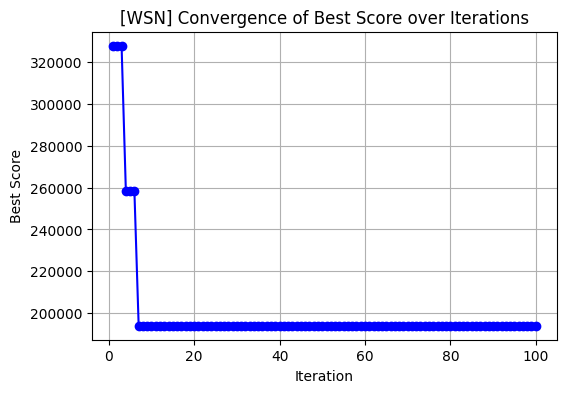

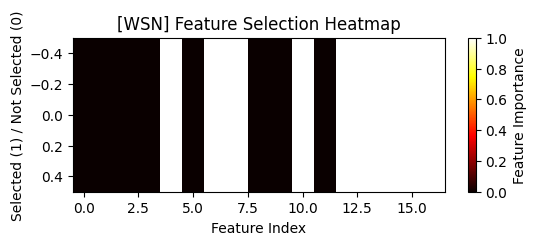



Mean Best Score: 199884.66364245513
Standard Deviation of Best Score: 25075.760413230193
Mean Classification Accuracy: 0.8660577444074619
Standard Deviation of Classification Accuracy: 0.0021552079888328924



In [23]:
# Trial 49 finished with value: 193950.79594137828 and parameters: {'c1': 0.8978613885305409, 'c2': 0.709705174918022, 'swarm_size': 42}. Best is trial 8 with value: 64625.53126015948.
# Best Hyperparameters: {'c1': 1.2605182267926252, 'c2': 0.5963300645127059, 'swarm_size': 41}


best_position, best_score, best_scores_over_time = PSOVA1(features, labels, 1.2605182267926252, 0.5963300645127059, 100, 41)
mean_accuracy, std_accuracy = calculate_accuracy(features, labels, best_position)

# Calculate mean and standard deviation of best scores
mean_score = np.mean(best_scores_over_time)
std_score = np.std(best_scores_over_time)

# Visualization of best score over iterations
print("")
print("="*110)
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_iter + 1), best_scores_over_time, marker='o', color='b')
plt.xlabel('Iteration')
plt.ylabel('Best Score')
plt.title('[WSN] Convergence of Best Score over Iterations')
plt.grid()
plt.show()

# Visualize best position in a feature heatmap
plt.figure(figsize=(6, 2))
plt.imshow(best_position.reshape(1, -1), cmap='hot', aspect='auto')
plt.colorbar(label='Feature Importance')
plt.title('[WSN] Feature Selection Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.show()

# Print results
print("")
print("="*110)
print("")
print("Mean Best Score:", mean_score)
print("Standard Deviation of Best Score:", std_score)
print("Mean Classification Accuracy:", mean_accuracy)
print("Standard Deviation of Classification Accuracy:", std_accuracy)
print("")
print("="*110)
# 35.3s

In [24]:
features_col = df.columns.to_list()
selected_features = [features_col[i] for i in range(len(best_position)) if best_position[i] == 1]
non_selected_features = [features_col[i] for i in range(len(best_position)) if best_position[i] == 0]

print(f"Selected Features:\n{selected_features}")
print(f"Non-Selected Features:\n{non_selected_features}")


Selected Features:
[' Dist_To_CH', ' ADV_R', ' JOIN_S', ' SCH_R', ' DATA_S', ' DATA_R', ' Data_Sent_To_BS', ' dist_CH_To_BS', ' send_code ']
Non-Selected Features:
[' id', ' Time', ' Is_CH', ' who CH', ' ADV_S', ' JOIN_R', ' SCH_S', 'Rank']
